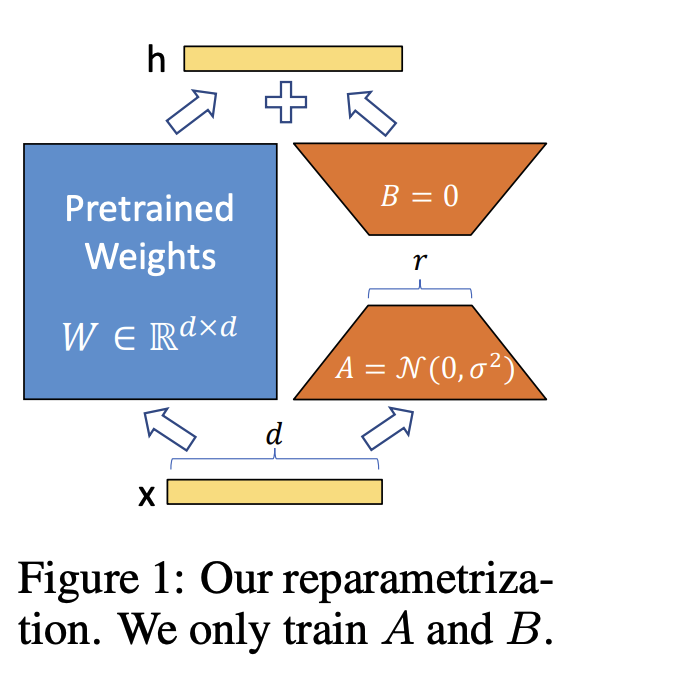

# LoRA 低秩适配器综述

随着大规模语言模型（LLM）的出现，模型参数往往达到数十亿甚至千亿。为了在微调时既保持训练效率又保证效果，LoRA 提出了在预训练模型权重旁引入低秩适配器，仅更新少量参数而不干扰原有模型输出的策略。

## 1. LoRA 基本原理

假设预训练权重矩阵为  
$$\mathbf{W} \in \mathbb{R}^{d \times k},$$  
LoRA 的方法是通过添加一个低秩更新项 $\Delta \mathbf{W}$ 来进行微调，即：  
$$\Delta \mathbf{W} = \mathbf{B}\mathbf{A},$$  
其中：  
- $\mathbf{A} \in \mathbb{R}^{r \times d}$ 为**降维矩阵**，  
- $\mathbf{B} \in \mathbb{R}^{k \times r}$ 为**升维矩阵**，  
- $r \ll \min(d, k)$ 是低秩维度，通常选取很小的值（如 1、2、4、8）。

在微调过程中，原始权重 $\mathbf{W}$ 保持不变，只更新 $\mathbf{A}$ 和 $\mathbf{B}$；最终更新后的权重为：  
$$\mathbf{W}' = \mathbf{W} + \alpha\, \mathbf{B}\mathbf{A},$$  
其中 $\alpha$ 是一个可调的缩放因子。

## 2. 初始化策略

为了确保在微调初期引入的更新  
$$\Delta \mathbf{W} = \mathbf{B}\mathbf{A}$$  
不改变预训练模型的行为，合理的初始化至关重要。

- **目标**：使初始时 $\Delta \mathbf{W} \approx 0$。

- **常见初始化方案**：  
  - **降维矩阵 $\mathbf{A}$**：  
    可以采用两种常见方式：
    
    1. **高斯初始化**：  
       使用正态分布进行初始化，  
       $$\mathbf{A} \sim \mathcal{N}(0, \sigma^2),$$  
       其中均值为 0，方差 $\sigma^2$ 通常取较小的值（例如 $\sigma = 0.02$），以保证初始更新项不至于太大。
    
    2. **Kaiming（He）初始化**：  
       Kaiming 初始化是一种专为深层网络设计的权重初始化方法，其目标是保持前向信号和反向梯度在网络层之间的稳定性。对于使用 ReLU 激活的网络，通常标准差为  
       $$\text{std} = \sqrt{\frac{2}{\text{fan\_in}}}.$$  
       在 LoRA 中使用 Kaiming 初始化对降维矩阵 $\mathbf{A}$ 是可行的，只要确保使用较小的尺度（或者通过缩放因子进行调整），以保证初始时 $\Delta \mathbf{W}$ 接近于零。因为只要升维矩阵 $\mathbf{B}$ 初始化为全零，  
       $$\Delta \mathbf{W} = \mathbf{B}\mathbf{A} = \mathbf{0}.$$
    
  - **升维矩阵 $\mathbf{B}$**：  
    为确保初始时 $\Delta \mathbf{W} = \mathbf{B}\mathbf{A} = 0$，通常将 $\mathbf{B}$ 初始化为全零矩阵。

## 3. LoRA 的优势

- **参数高效**：仅更新低秩适配器参数，显著减少需要更新的参数量。  
- **显存与计算效率**：冻结大部分预训练参数，降低显存和计算资源消耗。  
- **无额外推理延迟**：训练完成后可将更新直接合并到预训练权重中，推理时无需额外计算。

## 4. 总结

LoRA 利用低秩分解的方法，通过在预训练模型中引入低秩适配器实现高效微调。其核心更新公式为：  
$$\mathbf{W}' = \mathbf{W} + \alpha\, \mathbf{B}\mathbf{A},$$  
在初始化时，可以采用两种方式对降维矩阵 $\mathbf{A}$ 进行初始化：
- 使用均值为 0、方差较小（如 $\sigma=0.02$ 对应的正态分布）的高斯初始化；
- 或使用 Kaiming（He）初始化，该方法根据输入维度自动调节初始化尺度，以保持信号在深层网络中的稳定传播。  

同时，对升维矩阵 $\mathbf{B}$ 采用全零初始化，从而确保初始时 $\Delta \mathbf{W} = \mathbf{B}\mathbf{A} \approx 0$。



In [11]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math

class LinearLoRALayer(nn.Module):
    def __init__(self, in_features, out_features,
                 merge=False, rank=8, alpha=16,
                 dropout=0.1):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.merge = merge
        self.rank = rank

         # linear weight 的 Shape 是 (out_features, in_features), 正确的做法是 xW^T
        self.linear = nn.Linear(in_features, out_features)

        if rank > 0:
            # lora_a: (out_features, rank), lora_b: (rank, in_features)
            self.lora_a = nn.Parameter(torch.zeros(out_features, rank))
            nn.init.kaiming_normal_(self.lora_a, a=math.sqrt(5))
            self.lora_b = nn.Parameter(torch.zeros(rank, in_features))

            self.scale = alpha / rank
            self.linear.weight.requires_grad = False

        if dropout > 0:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = nn.Identity()
        
        if merge:
            self.merge_weight()
        
    def forward(self, x):
        if self.rank > 0 and not self.merge:
            # lora_a: (out_features, rank), lora_b: (rank, in_features)
            # -> self.lora_a @ self.lora_b: (out_features, in_features)
            # -> .T(in_features, in_features)
            # x:(batch_size, seq_len, in_features)
            # output: (batch_size, seq_len, out_features)
            output = self.linear(x) + self.scale * (x @ (self.lora_a @ self.lora_b).T)
        
        elif self.rank > 0 and self.merge:
            output = self.linear(x)
        else:
            output = self.linear(x)

        return self.dropout(output)
    
    # merge shape is correct?
    def merge_weight(self):
        if self.merge and self.rank > 0:
            
            print(f"self.linear.weight.data.size() is {self.linear.weight.data.size()}")
            print(f"self.lora_a @ self.lora_b is {(self.lora_a @ self.lora_b).size()}")
                # -> self.lora_a @ self.lora_b: (out_features, in_features)
            self.linear.weight.data += self.scale * (self.lora_a @ self.lora_b)
    
    def unmerge_weight(self):
        if self.rank > 0:
            self.linear.weight.data -= self.scale * (self.lora_a @ self.lora_b)

In [12]:
# 写一段测试代码
# Test the LoRALinear layer
batch_size = 32
seq_len = 128
in_features = 768
out_features = 512
rank = 8
lora_alpha = 16
dropout = 0.1

In [13]:
x = torch.randn(batch_size, seq_len, in_features)

In [14]:
x

tensor([[[ 5.2669e-02,  3.0058e-01, -4.4615e-01,  ...,  4.3215e-01,
           6.5952e-01, -5.8921e-01],
         [-5.6145e-01,  3.6246e-01,  1.1968e+00,  ...,  3.7351e-01,
           6.6864e-01,  7.8460e-01],
         [-1.4560e+00, -6.0980e-01,  5.2691e-01,  ...,  1.5210e-02,
           1.3173e+00,  1.7329e+00],
         ...,
         [-1.5201e+00,  2.1220e+00,  7.8214e-01,  ...,  1.3837e+00,
          -1.1177e+00,  6.3969e-01],
         [-5.7042e-01, -8.7735e-01,  1.8065e+00,  ..., -2.4458e+00,
          -1.1554e-03,  1.0514e+00],
         [ 1.6654e+00, -1.2093e+00,  7.1225e-01,  ..., -9.8851e-02,
          -8.2459e-01, -5.8121e-01]],

        [[-9.2079e-02,  1.1134e-01,  2.0760e+00,  ...,  1.7600e+00,
          -6.6146e-01, -1.7178e+00],
         [-1.0170e+00,  3.1746e-01,  1.1742e+00,  ..., -6.4243e-01,
           1.1842e+00, -2.6848e-02],
         [-1.3622e+00,  6.2648e-01, -4.6860e-01,  ...,  1.3585e+00,
          -2.6241e-01,  9.4450e-02],
         ...,
         [ 4.2884e-01,  9

In [15]:
# Test regular mode (no merge)
lora_layer = LinearLoRALayer(
    in_features=in_features,
    out_features=out_features,
    rank=rank,
    alpha=lora_alpha,
    dropout=dropout,
    merge=False
)

In [16]:
# Forward pass
output = lora_layer(x)
# Should be [batch_size, seq_len, out_features]
print(f"Output shape (no merge): {output.shape}")  

Output shape (no merge): torch.Size([32, 128, 512])


In [17]:
in_features, out_features

(768, 512)

In [18]:
# Test merged mode

out_features = 512

lora_layer_merged = LinearLoRALayer(
    in_features=in_features,
    out_features=out_features,
    rank=rank,
    alpha=lora_alpha,
    dropout=dropout,
    merge=True
)

self.linear.weight.data.size() is torch.Size([512, 768])
self.lora_a @ self.lora_b is torch.Size([512, 768])


In [19]:
# Forward pass with merged weights
output_merged = lora_layer_merged(x)
print(f"Output shape (merged): {output_merged.shape}")  # Should be [batch_size, seq_len, out_features]

# Test weight merging/unmerging
lora_layer.merge_weight()
output_after_merge = lora_layer(x)
lora_layer.unmerge_weight()
output_after_unmerge = lora_layer(x)

print("Max difference after merge/unmerge cycle:", 
      torch.max(torch.abs(output - output_after_unmerge)).item())

Output shape (merged): torch.Size([32, 128, 512])
Max difference after merge/unmerge cycle: 2.913344144821167
